# Laboratorio 06 - GANs

Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

### Librerías

In [1]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Preparación de los datos

In [2]:
image_dir = './data/img_align_celeba/img_align_celeba'

transform = transforms.Compose([
    transforms.CenterCrop(128),                                          # Recorte central
    transforms.Resize((128, 128)),                                       # Redimensionar a 128x128
    transforms.ToTensor(),                                               # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])      # Normalizar
])

**IAGen prompt:** Using a large dataset of images as "[CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/)" for training a GAN. Which is the best way to load the data?

In [3]:
def load_images_in_batches(image_dir, batch_size=64):
    image_files = os.listdir(image_dir)
    
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        images = []
        for file in batch_files:
            img_path = os.path.join(image_dir, file)
            image = Image.open(img_path)
            image = transform(image)
            images.append(image)
        yield torch.stack(images)  

batch_size = 64

image_batch_gen = load_images_in_batches(image_dir, batch_size=batch_size)

first_batch = next(image_batch_gen)

print(f"Tamaño del primer lote: {first_batch.shape}")

Tamaño del primer lote: torch.Size([64, 3, 128, 128])


**IAGen prompt:** How can I verify that the preprocessing is done correctly?

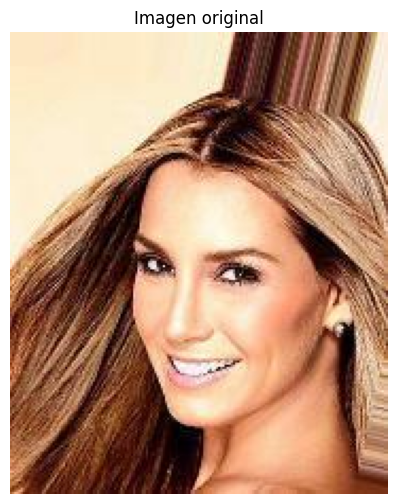

In [4]:
image_files = os.listdir(image_dir)
image_path = os.path.join(image_dir, image_files[0])
image = Image.open(image_path)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Imagen original")
plt.axis('off')
plt.show()

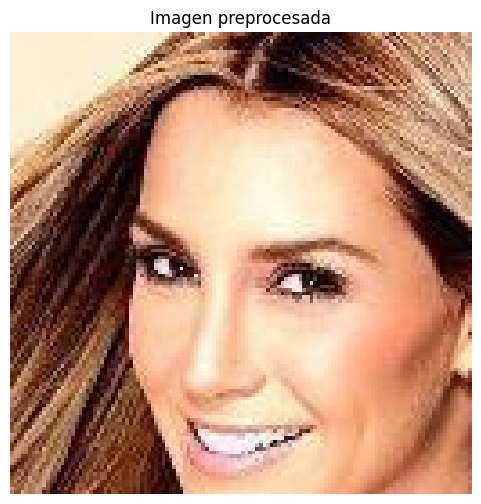

In [5]:
image_transformed = transform(image)

def denormalize(tensor):
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return torch.clamp(tensor, 0, 1)

image_denorm = denormalize(image_transformed)

image_np = image_denorm.permute(1, 2, 0).numpy()

plt.figure(figsize=(6,6))
plt.imshow(image_np)
plt.title("Imagen preprocesada")
plt.axis('off')
plt.show()

### Implementación de la GAN

**IAGen prompt:** Give me an example of layers to develop a generator of a GAN for output images on 128x128.

#### Generador

In [6]:
latent_dim = 100

generator = nn.Sequential(
    # Capa 1: Vector de ruido -> salida será 1024 canales de 4x4
    nn.ConvTranspose2d(latent_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    # Capa 2: 1024 canales de 4x4 -> salida será 512 canales de 8x8
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # Capa 3: 512 canales de 8x8 -> salida será 256 canales de 16x16
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # Capa 4: 256 canales de 16x16 -> salida será 128 canales de 32x32
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # Capa 5: 128 canales de 32x32 -> salida será 64 canales de 64x64
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # Capa 6: 64 canales de 64x64 -> salida será 3 canales de 128x128 (RGB)
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  
)

noise = torch.randn(1, latent_dim, 1, 1)

fake_image = generator(noise)

print(f"Dimensiones de la imagen generada: {fake_image.shape}")

Dimensiones de la imagen generada: torch.Size([1, 3, 128, 128])


**IAGen prompt:** Now, based on the implemented generator, develop the discriminator.
#### Discriminador

In [7]:
discriminator = nn.Sequential(
    # Capa 1: 3 canales de entrada (imagen RGB) -> salida 64 canales de 64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 2: 64 canales de 64x64 -> salida 128 canales de 32x32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 3: 128 canales de 32x32 -> salida 256 canales de 16x16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 4: 256 canales de 16x16 -> salida 512 canales de 8x8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 5: 512 canales de 8x8 -> reducir dimensiones espaciales a 1x1
    nn.AdaptiveAvgPool2d((1,1)),

    nn.Flatten(),

    nn.Linear(512, 1),
    nn.Sigmoid()
)


**IAGen prompt:** Having already implemented the generator and discriminator, it's time to define the loss functions and optimizers to train the GAN. Please develop an example of them.
#### Funciones de pérdida y optimizadores

In [8]:
criterion = nn.BCELoss()

lr = 0.0001 
beta1 = 0.5 

optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

real_label = 1.
fake_label = 0.

batch_size = 64

real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)

### Entrenamiento de la GAN

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)
print(f"Dispositivo: {device}")

Dispositivo: cuda


Epoca [1/10] Lote [0/3165] Pérdida D: 1.3942, Pérdida G: 0.7230
Epoca [1/10] Lote [100/3165] Pérdida D: 0.7499, Pérdida G: 1.3196
Epoca [1/10] Lote [200/3165] Pérdida D: 0.4855, Pérdida G: 1.6150
Epoca [1/10] Lote [300/3165] Pérdida D: 0.3125, Pérdida G: 1.9617
Epoca [1/10] Lote [400/3165] Pérdida D: 1.0431, Pérdida G: 1.4189
Epoca [1/10] Lote [500/3165] Pérdida D: 1.0937, Pérdida G: 1.0889
Epoca [1/10] Lote [600/3165] Pérdida D: 1.0445, Pérdida G: 0.9918
Epoca [1/10] Lote [700/3165] Pérdida D: 1.1065, Pérdida G: 1.2694
Epoca [1/10] Lote [800/3165] Pérdida D: 1.0408, Pérdida G: 1.0376
Epoca [1/10] Lote [900/3165] Pérdida D: 1.1833, Pérdida G: 1.1578
Epoca [1/10] Lote [1000/3165] Pérdida D: 0.8606, Pérdida G: 1.4337
Epoca [1/10] Lote [1100/3165] Pérdida D: 1.2194, Pérdida G: 1.5521
Epoca [1/10] Lote [1200/3165] Pérdida D: 1.0082, Pérdida G: 1.4917
Epoca [1/10] Lote [1300/3165] Pérdida D: 0.9568, Pérdida G: 1.3159
Epoca [1/10] Lote [1400/3165] Pérdida D: 1.1709, Pérdida G: 0.8352
Epoca [

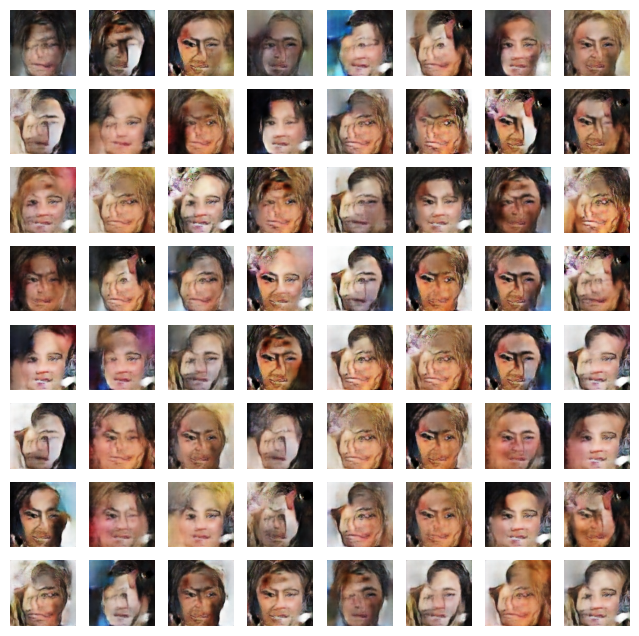

Epoca [6/10] Lote [0/3165] Pérdida D: 0.1069, Pérdida G: 3.1686
Epoca [6/10] Lote [100/3165] Pérdida D: 0.2280, Pérdida G: 3.1488
Epoca [6/10] Lote [200/3165] Pérdida D: 0.2714, Pérdida G: 3.1631
Epoca [6/10] Lote [300/3165] Pérdida D: 0.3699, Pérdida G: 3.6012
Epoca [6/10] Lote [400/3165] Pérdida D: 0.1918, Pérdida G: 2.9132
Epoca [6/10] Lote [500/3165] Pérdida D: 0.3838, Pérdida G: 2.1174
Epoca [6/10] Lote [600/3165] Pérdida D: 0.3981, Pérdida G: 4.9420
Epoca [6/10] Lote [700/3165] Pérdida D: 0.1586, Pérdida G: 2.8372
Epoca [6/10] Lote [800/3165] Pérdida D: 0.0929, Pérdida G: 3.7408
Epoca [6/10] Lote [900/3165] Pérdida D: 0.2045, Pérdida G: 3.4351
Epoca [6/10] Lote [1000/3165] Pérdida D: 0.1504, Pérdida G: 3.3718
Epoca [6/10] Lote [1100/3165] Pérdida D: 0.1396, Pérdida G: 3.1797
Epoca [6/10] Lote [1200/3165] Pérdida D: 0.2810, Pérdida G: 3.0838
Epoca [6/10] Lote [1300/3165] Pérdida D: 0.2698, Pérdida G: 3.7912
Epoca [6/10] Lote [1400/3165] Pérdida D: 0.1499, Pérdida G: 3.1595
Epoca [

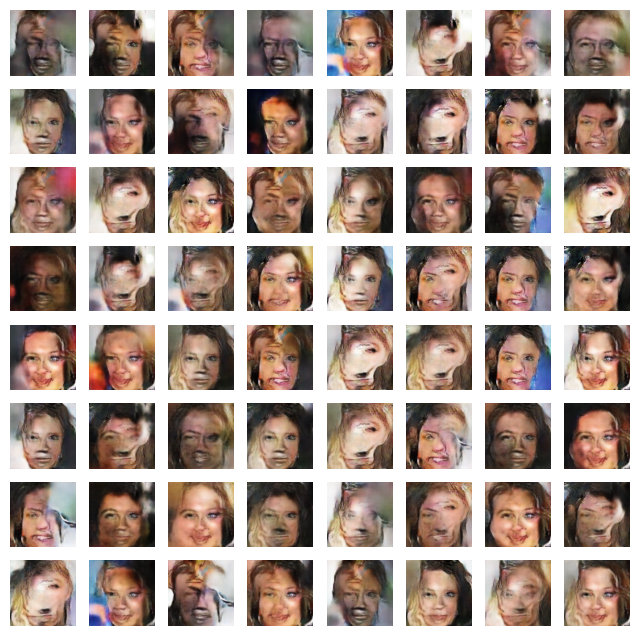

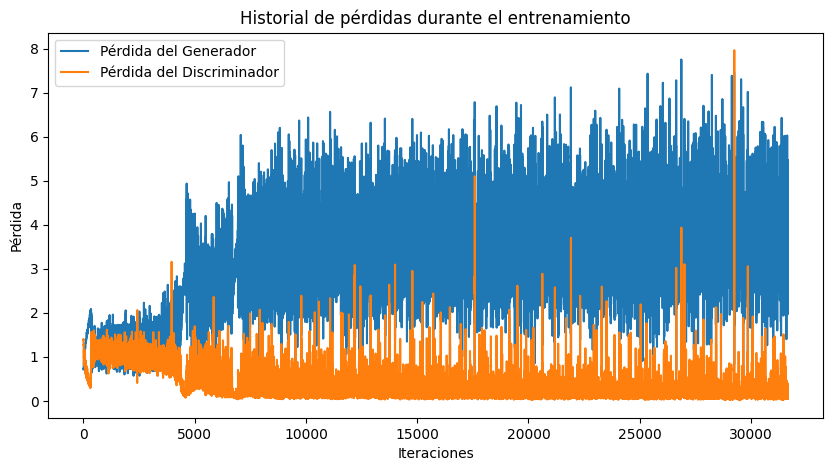

In [10]:
num_epochs = 10
print_interval = 100 
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) 

G_losses = []
D_losses = []

real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    for i, real_images in enumerate(load_images_in_batches(image_dir, batch_size=batch_size)):
        ############################
        # (1) Actualizar Discriminador
        ############################
        discriminator.zero_grad()
        real_images = real_images.to(device)
        real_output = discriminator(real_images).view(-1)
        real_labels = torch.full_like(real_output, real_label, dtype=torch.float, device=device)
        real_loss = criterion(real_output, real_labels)
        real_loss.backward()

        noise = torch.randn(len(real_images), latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach()).view(-1)
        fake_labels = torch.full_like(fake_output, fake_label, dtype=torch.float, device=device)
        fake_loss = criterion(fake_output, fake_labels)
        fake_loss.backward()
        optimizerD.step()

        ############################
        # (2) Actualizar Generador
        ############################
        generator.zero_grad()
        output = discriminator(fake_images).view(-1)
        gen_labels = torch.full_like(output, real_label, dtype=torch.float, device=device)
        gen_loss = criterion(output, gen_labels)
        gen_loss.backward()
        optimizerG.step()

        D_losses.append(real_loss.item() + fake_loss.item())
        G_losses.append(gen_loss.item())


        if i % print_interval == 0:
            print(f'Epoca [{epoch+1}/{num_epochs}] Lote [{i}/{len(os.listdir(image_dir)) // batch_size}] '
                  f'Pérdida D: {D_losses[-1]:.4f}, Pérdida G: {G_losses[-1]:.4f}')

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        fig, ax = plt.subplots(8, 8, figsize=(8, 8))
        for j in range(8):
            for k in range(8):
                ax[j, k].imshow(denormalize(fake_images[j * 8 + k]).permute(1, 2, 0).numpy())
                ax[j, k].axis('off')
        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Pérdida del Generador")
plt.plot(D_losses, label="Pérdida del Discriminador")
plt.title("Historial de pérdidas durante el entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.legend()
plt.show()


Como se puede observar, con 10 épocas la generación de imágenes no es muy buena, aunque se puede observar que el generador está aprendiendo. Se puede observar que el generador está aprendiendo a generar imágenes de rostros, aunque no son muy claras. Se puede apreciar que elementos faciales como ojos, nariz y boca están presentes en las imágenes generadas, aunque no son muy claros o estén distorsionados. 

En el caso de las pérdidas del generador y del discriminador, se puede observar que la pérdida del discriminador disminuye con el tiempo, mientras que la pérdida del generador aumenta. Esto es lo que se espera, ya que el generador busca engañar al discriminador, por lo que su pérdida debería disminuir, mientras que el discriminador busca identificar las imágenes reales de las generadas, por lo que su pérdida debería aumentar.

### Reflexión

* *1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?*
El concepto de GANs si bien lo vimos en deep learning, es un tema que no habíamos implementado como tal. Personalmente, tenía un concepto erroneo de como se entrenaban las GANs, pensaba que se entrenaban por separado y no en conjunto. Por otro lado, el concepto de las funciones de pérdida y optimizadores fue un poco más sencillo de entender, ya que es algo que hemos visto en laboratorios anteriores.

* *2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?*
El laboratorio nos ayudó a entender mejor el concepto de GANs, ya que al implementarlas pudimos ver como se entrenan en conjunto y como se van actualizando los pesos de cada red. Creo que el hecho de buscar por nuestra cuenta información adicional sobre las GANs también nos ayudó a entender mejor el concepto, ya que pudimos ver ejemplos de implementaciones y entender mejor como funcionan.

* *3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?*
Como vimos en el curso de deep learning, las GANs se pueden utilizar para generar imágenes de productos que aún no existen, para generar imágenes de personas que no existen, para generar imágenes de interiores de casas, entre otros. En la investigación, las GANs se pueden utilizar para generar imágenes de células, para generar imágenes de galaxias, entre otros. Creo que las GANs tienen un gran potencial en la industria y en la investigación, ya que permiten generar imágenes de alta calidad de cosas que no existen. Un claro ejemplo es en el diseño de moda, donde se pueden generar imágenes de ropa que aún no existen y ver como se verían en una persona. Sin embargo, como se vio en clase, está el problema de que se ajuste el generador a un solo tipo de imagen, por lo que se debe tener cuidado con eso.

* *4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?*
Dentro de las limitaciones de las GANs, como mencioné anteriormente, se encuentra el problema de que se ajuste el generador a un solo tipo de imagen, lo que puede llevar a que se generen imágenes que no son realistas. Por otro lado, las GANs pueden ser utilizadas para generar imágenes falsas de personas, lo que puede llevar a problemas éticos. Por ejemplo, se pueden generar imágenes de personas que no existen y utilizarlas para hacer campañas de publicidad, lo que puede llevar a que las personas crean que esa persona existe. 

* *5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la experiencia práctica?*
Después de la experiencia práctica, nos sentimos más seguros con respecto a la implementación y entrenamiento de GANs. Creo que el hecho de haber implementado una GAN desde cero nos ayudó a entender mejor como funcionan y como se entrenan. Además, el hecho de haber buscado información adicional sobre las GANs nos ayudó a entender mejor el concepto y a ver ejemplos de implementaciones. Creo que las GANs son una herramienta muy poderosa y que tienen un gran potencial en la industria y en la investigación siempre y cuando se utilicen de manera ética.